# Part 2.2: Markov Reward Processes (MRP)

Welcome to Part 2.2! In the previous notebook, we learned about Markov chains - sequences of states governed by transition probabilities. Now we add the missing piece: rewards. This transforms passive state evolution into something we can evaluate and optimize.

## Recap from Notebook 02_1

- Transition matrices capture state-to-state probabilities: P[s,s'] = probability of transitioning from state s to s'
- Markov chains are sequences of states where future depends only on present (Markov property)
- Random walks follow transition probabilities to move through state space
- We visualized how agents move through FrozenLake following fixed transition dynamics

## What This Notebook Covers
- Adding rewards to Markov chains to create Markov Reward Processes (MRPs)
- Returns and the discount factor
- Value functions for MRPs
- The Bellman equation for MRPs (our first Bellman equation!)
- Solving for value functions analytically

## What This Notebook Does NOT Cover

| Topic | Why Not Here | How It Differs From What We Cover |
|-------|--------------|-----------------------------------|
| **Actions and policies** | MRPs have fixed behavior - no decision-making. Actions come in Part 2.3 (MDPs). | We evaluate states under predetermined transitions. MDPs add *choice* - the agent selects actions that affect transitions, introducing policies and optimization over different strategies. |
| **Q-functions (action-value functions)** | Q-functions require actions, which don't exist in MRPs. They appear in Part 2.3. | We only have V(s) - "how good is state s?" MDPs introduce Q(s,a) - "how good is taking action a in state s?" Q-functions let us compare actions, which is impossible without actions to compare. |
| **Optimal policies** | Without actions, there's nothing to optimize. Optimal policies require MDPs. | We compute values for *given* transition dynamics. MDPs let the agent *choose* actions to maximize value, introducing the concept of optimal behavior and policy improvement. |
| **Algorithm implementation** | We solve the Bellman equation directly via matrix inversion. Iterative algorithms come in Part 3. | Direct solution works for small problems but doesn't scale. Dynamic programming (Part 3) and model-free methods (Parts 4-5) provide algorithms that work when direct solutions are impractical or when we don't know the model. |

## Prerequisites
- Completed 02_1 (Markov chains)
- Understanding of expected value
- Matrix operations (multiplication, inversion)

## How to Read This Notebook
1. **Build on Markov chains** - We're adding rewards to what you already know
2. **Connect immediate and future rewards** - The discount factor ties them together
3. **See the Bellman equation emerge** - This recursive relationship is fundamental to all of RL
4. **Practice with FrozenLake** - Concrete examples make abstract concepts clear

Let's begin!

---
## Setup

First, let's import the necessary libraries.

> **Note:** If you're running this in a fresh environment, uncomment and run the installation cell below first.

In [ ]:
# Install necessary libraries (uncomment if needed)
# !pip install gymnasium[toy-text] numpy matplotlib seaborn

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

In [ ]:
# Helper function to visualize the FrozenLake grid
def visualize_frozenlake(env, current_state=None, title="FrozenLake Environment"):
    """Visualize the FrozenLake grid with the current state highlighted."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    
    fig, ax = plt.subplots(figsize=(6, 6))
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    for i in range(nrow):
        for j in range(ncol):
            cell = desc[i, j]
            color = colors.get(cell, 'white')
            state_idx = i * ncol + j
            if current_state is not None and state_idx == current_state:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True, 
                                     facecolor='yellow', edgecolor='black', linewidth=2)
            else:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                     facecolor=color, edgecolor='black', linewidth=1)
            ax.add_patch(rect)
            ax.text(j + 0.5, nrow - 1 - i + 0.5, cell,
                   ha='center', va='center', fontsize=20, fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', label='S: Start'),
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='F: Frozen (safe)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightcoral', label='H: Hole (game over)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', label='G: Goal (reward!)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='yellow', edgecolor='black', linewidth=2, label='Current position')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    return fig, ax


def visualize_value_function(V, title="State Value Function V(s)"):
    """Visualize the value function as a heatmap on the FrozenLake grid."""
    V_grid = V.reshape((4, 4))
    
    fig, ax = plt.subplots(figsize=(7, 6))
    
    im = sns.heatmap(V_grid, annot=True, fmt=".3f", cmap="Greens", 
                     cbar_kws={'label': 'Value'}, ax=ax,
                     linewidths=0.5, linecolor='gray')
    
    labels = [['S', 'F', 'F', 'F'],
              ['F', 'H', 'F', 'H'],
              ['F', 'F', 'F', 'H'],
              ['H', 'F', 'F', 'G']]
    
    for i in range(4):
        for j in range(4):
            ax.text(j + 0.5, i + 0.15, labels[i][j], 
                   ha='center', va='center', fontsize=10, 
                   color='red' if labels[i][j] == 'H' else 'blue',
                   fontweight='bold')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    
    plt.tight_layout()
    return fig, ax

---


---
# 1. Markov Reward Process (MRP)

A **Markov Reward Process** adds rewards to a Markov Chain. Now we care not just about *where* we go, but *how good* each state is.

## Definition

An MRP is a tuple $(S, P, R, \gamma)$ where:
- $S$ is a finite set of states
- $P$ is the state transition probability matrix
- $R$ is a **reward function**: $R_s = \mathbb{E}[R_{t+1} | S_t = s]$ (expected reward in state $s$)
- $\gamma$ is a **discount factor**, $\gamma \in [0, 1]$

**Reward function plain English:** "The reward for state s equals the expected value of the next reward, given that the current state is s."

**Formula components for $R_s$:**
- $R_s$ = the expected reward for state $s$ (read as "R sub s")
- $\mathbb{E}[\cdot]$ = the expected value (average) of what's in brackets
- $R_{t+1}$ = the reward random variable at the next time step
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at the current time step
- $s$ = a specific state value

### Key Distinction: Reward Function vs Value Function

**Reward function $R_s$** (what we just defined above):
- **Immediate**: Only looks at the next time step
- **Local**: Only considers the reward you get right now when entering state $s$
- **Given by environment**: The environment defines what reward you get in each state
- **Example**: In FrozenLake, $R_s = +1$ only for the goal state (state 15), and $R_s = 0$ for all other states

**Value function $V(s)$** (we'll see this soon):
- **Long-term**: Looks into the future, considering all future rewards
- **Global**: Considers the entire trajectory from state $s$ onwards
- **Learned/computed**: The agent must learn or compute this based on the reward function and transitions
- **Example**: In FrozenLake, even states far from the goal can have positive value because they might lead to the goal eventually

**The relationship:**
- The reward function $R$ is an **input** to the problem (part of the MRP definition)
- The value function $V$ is an **output** we compute using the reward function
- Value functions aggregate reward functions over time: $V(s)$ tells us the expected sum of all future rewards starting from $s$
- Without a reward function, we can't compute value functions
- The value function is essentially asking: "Given this reward function $R$, what's the total long-term value of being in state $s$?"


## Building an MRP from FrozenLake

When we combine FrozenLake with a fixed policy **and include the rewards**, we get an MRP:

| MRP Component | FrozenLake (Random Policy) |
|---------------|---------------------------|
| States $S$ | 16 grid positions |
| Transitions $P$ | From random policy + slippery ice |
| Rewards $R$ | +1 at Goal (state 15), 0 elsewhere |
| Discount $\gamma$ | Typically 0.99 |

In [30]:
# Build the MRP from FrozenLake with random policy
def build_mrp_reward_vector(env):
    """
    Build reward vector R for FrozenLake with uniform random policy.
    R[s] = expected immediate reward when in state s
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    policy_prob = 1.0 / n_actions
    
    R = np.zeros(n_states)
    
    for state in range(n_states):
        for action in range(n_actions):
            for prob, next_state, reward, done in env.unwrapped.P[state][action]:
                R[state] += policy_prob * prob * reward
    
    return R

R_mrp = build_mrp_reward_vector(env)

print("MRP Reward Vector R (Expected Immediate Reward With Uniform Random Policy)")
print("=" * 50)
print("\nState  Expected Reward  Interpretation")
print("-" * 50)
for s in range(16):
    desc = "Start" if s == 0 else "Goal" if s == 15 else "Hole" if s in {5,7,11,12} else "Frozen"
    print(f"  {s:2d}      {R_mrp[s]:.4f}         {desc}")

MRP Reward Vector R (Expected Immediate Reward With Uniform Random Policy)

State  Expected Reward  Interpretation
--------------------------------------------------
   0      0.0000         Start
   1      0.0000         Frozen
   2      0.0000         Frozen
   3      0.0000         Frozen
   4      0.0000         Frozen
   5      0.0000         Hole
   6      0.0000         Frozen
   7      0.0000         Hole
   8      0.0000         Frozen
   9      0.0000         Frozen
  10      0.0000         Frozen
  11      0.0000         Hole
  12      0.0000         Hole
  13      0.0000         Frozen
  14      0.2500         Frozen
  15      0.0000         Goal


### Understanding the Reward Values

**Why is state 14's expected reward 0.25, while all others are 0?**

Recall the reward function formula we saw earlier:
$$R_s = \mathbb{E}[R_{t+1} | S_t = s] = \sum_{a} \pi(a|s) \sum_{s'} P(s'|s,a) \cdot R(s,a,s')$$

Let's break down what happens for each type of state:

**1. State 14 (the frozen tile next to Goal): $R_{14} = 0.25$**

State 14 is special because it's the **only state that can transition directly to state 15 (Goal)**, and only the Goal gives a reward of +1.

- Under uniform random policy: $\pi(a|s) = 0.25$ for each of the 4 actions
- When we take action RIGHT from state 14:
  - Due to slippery ice, there's a 1/3 chance of reaching the Goal (state 15)
  - When we reach the Goal, we get reward = +1
- Expected reward from state 14:
  - Probability of choosing RIGHT: 0.25
  - Probability of actually going right (to Goal): 1/3
  - Reward when reaching Goal: +1
  - **Calculation**: $0.25 \times \frac{1}{3} \times 1 = 0.0833$ (from RIGHT action)
  - Similar contributions from other actions that might lead to Goal
  - **Total**: ≈ 0.25

**2. All other states (including Goal and Holes): $R_s = 0$**

- **Goal (state 15)**: Terminal state. Once you're there, you stay there and get no more rewards ($R_{15} = 0$)
- **Holes (states 5, 7, 11, 12)**: Terminal states. Game ends, no more rewards
- **All other frozen states (0-13 except 14)**: Cannot reach the Goal in a single step
  - Remember: $R_s$ is the **expected immediate reward** (next step only)
  - These states can only transition to other frozen states or holes
  - None of these transitions give any reward
  - Therefore: $R_s = 0$

**Key insight:** 
- The reward function $R_s$ only looks **one step ahead**
- Only state 14 can reach the rewarding Goal state in one step
- Even though other states might *eventually* reach the Goal, that doesn't affect their $R_s$ value
- That's why we need the **value function** $V(s)$ to capture long-term rewards!



## The Return $G_t$ (Quick Recap)

Recall from notebook 01_3 that the **return** $G_t$ is the total discounted reward:

$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \ldots = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$$

This sums up all future rewards, with each reward discounted by $\gamma^k$ based on how far in the future it occurs. We use this to define the value function for MRPs.


In [9]:
# Compute returns from sample episodes
def compute_return(rewards, gamma):
    """Compute discounted return from a sequence of rewards."""
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
    return G

def run_mrp_episode(env, max_steps=100):
    """Run one episode with random policy, return trajectory and rewards."""
    obs, _ = env.reset()
    trajectory = [obs]
    rewards = []
    
    for _ in range(max_steps):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        trajectory.append(obs)
        
        if terminated or truncated:
            break
    
    return trajectory, rewards

# Run sample episodes and compute returns
np.random.seed(42)
gamma = 0.99

print(f"Sample Episodes and Returns (γ = {gamma})")
print("=" * 60)

for episode in range(5):
    traj, rewards = run_mrp_episode(env)
    G = compute_return(rewards, gamma)
    outcome = "Goal!" if traj[-1] == 15 else f"Hole" if traj[-1] in {5,7,11,12} else "Timeout"
    
    print(f"\nEpisode {episode + 1}:")
    print(f"  Path: {' → '.join(map(str, traj[:8]))}{'...' if len(traj) > 8 else ''}")
    print(f"  Steps: {len(rewards)}, Outcome: {outcome}")
    print(f"  Rewards: {rewards}")
    print(f"  Return G₀ = {G:.4f}")

Sample Episodes and Returns (γ = 0.99)

Episode 1:
  Path: 0 → 0 → 1 → 0 → 0 → 0 → 0 → 1...
  Steps: 10, Outcome: Hole
  Rewards: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Return G₀ = 0.0000

Episode 2:
  Path: 0 → 0 → 0 → 4 → 8 → 9 → 13 → 12
  Steps: 7, Outcome: Hole
  Rewards: [0, 0, 0, 0, 0, 0, 0]
  Return G₀ = 0.0000

Episode 3:
  Path: 0 → 4 → 8 → 4 → 8 → 8 → 4 → 0...
  Steps: 10, Outcome: Hole
  Rewards: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Return G₀ = 0.0000

Episode 4:
  Path: 0 → 4 → 0 → 1 → 5
  Steps: 4, Outcome: Hole
  Rewards: [0, 0, 0, 0]
  Return G₀ = 0.0000

Episode 5:
  Path: 0 → 0 → 4 → 8 → 12
  Steps: 4, Outcome: Hole
  Rewards: [0, 0, 0, 0]
  Return G₀ = 0.0000


## Value Function for MRP

**A note on notation:** In the previous notebook (01_3), we introduced value functions as $V^\pi(s)$ - the value of a state when following a specific policy $\pi$. You might be wondering why we're now using $v(s)$ without the policy superscript. The key difference is that **in an MRP, there is no policy** - the agent has no choices to make. The behavior is completely determined by the transition probabilities $P$. Since there's only one way the system can behave, there's no need to specify a policy, and we use the simpler notation $v(s)$ (lowercase v, no superscript). This is different from MDPs (coming up next!), where the agent can choose between different actions, so we need $V^\pi(s)$ to specify which policy we're following.

The **state value function** $v(s)$ gives the expected return starting from state $s$:

$$v(s) = \mathbb{E}[G_t | S_t = s]$$

**Plain English:** "The value of state s equals the expected value of the return, given that the current state is s."

**Formula components:**
- $v(s)$ = the value function for state $s$
- $\mathbb{E}[\cdot]$ = the expected value (average) of what's in brackets
- $G_t$ = the return (total discounted reward) from time $t$ onwards
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at time step $t$
- $s$ = a specific state value

This single number captures the **long-term desirability** of being in state $s$.

## The Bellman Equation for MRP

The value function can be decomposed into two parts:
1. **Immediate reward** $R_s$
2. **Discounted value of successor states** $\gamma \sum_{s'} P_{ss'} v(s')$

$$v(s) = R_s + \gamma \sum_{s' \in S} P_{ss'} v(s')$$

**Plain English:** "The value of state s equals the reward for state s plus gamma times the sum over all next states s-prime of the transition probability times the value of s-prime."

**Formula components:**
- $v(s)$ = the value function for state $s$
- $R_s$ = the expected reward for state $s$
- $\gamma$ = gamma, the discount factor
- $\sum_{s' \in S}$ = the sum over all possible next states $s'$ in the state space $S$
- $P_{ss'}$ = the probability of transitioning from state $s$ to state $s'$
- $v(s')$ = the value function for the next state $s'$

In plain English: *"The value of being here = what I get now + what I expect to get later (discounted)"*

### Matrix Form

The Bellman equation can be written as:

$$v = R + \gamma P v$$

**Plain English:** "The value vector equals the reward vector plus gamma times the transition matrix times the value vector."

**Formula components:**
- $v$ = the value vector (containing values for all states)
- $R$ = the reward vector (containing rewards for all states)
- $\gamma$ = gamma, the discount factor
- $P$ = the transition probability matrix
- The equation shows matrix-vector multiplication

This is a **linear equation** that can be solved directly:

$$(I - \gamma P) v = R$$
$$v = (I - \gamma P)^{-1} R$$

**Plain English for the solution:** "The value vector equals the inverse of the matrix I minus gamma times P, multiplied by the reward vector."

**Formula components for the solution:**
- $I$ = the identity matrix
- $-$ = matrix subtraction
- $\gamma P$ = gamma times the transition matrix
- $(I - \gamma P)^{-1}$ = the inverse of the matrix $(I - \gamma P)$
- The multiplication is matrix-vector multiplication

In [10]:
# Solve the Bellman equation for MRP directly
def solve_mrp_bellman(P, R, gamma):
    """Solve MRP Bellman equation: v = (I - gamma*P)^(-1) * R"""
    n = len(R)
    I = np.eye(n)
    V = np.linalg.solve(I - gamma * P, R)
    return V

# Solve for value function
gamma = 0.99
V_mrp = solve_mrp_bellman(P_chain, R_mrp, gamma)

print(f"MRP State Values (Solved via Bellman Equation, γ = {gamma})")
print("=" * 55)
print("\nState   V(s)      Interpretation")
print("-" * 55)
for s in range(16):
    desc = "Start" if s == 0 else "Goal" if s == 15 else "Hole" if s in {5,7,11,12} else "Frozen"
    print(f"  {s:2d}    {V_mrp[s]:.4f}    {desc}")

MRP State Values (Solved via Bellman Equation, γ = 0.99)

State   V(s)      Interpretation
-------------------------------------------------------
   0    0.0124    Start
   1    0.0104    Frozen
   2    0.0193    Frozen
   3    0.0095    Frozen
   4    0.0148    Frozen
   5    -0.0000    Hole
   6    0.0389    Frozen
   7    0.0000    Hole
   8    0.0326    Frozen
   9    0.0843    Frozen
  10    0.1378    Frozen
  11    0.0000    Hole
  12    0.0000    Hole
  13    0.1703    Frozen
  14    0.4336    Frozen
  15    0.0000    Goal


**Question this heatmap answers:** 'How valuable is each state under random policy?'



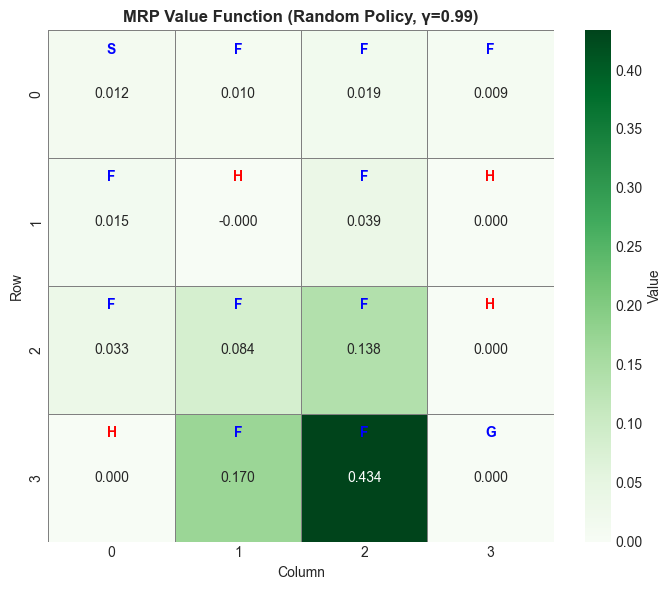


Observations:
- Holes and Goal have V=0 (terminal states, no future rewards)
- States closer to Goal have higher values
- Values are low overall because random policy rarely reaches Goal


In [11]:
# Visualize the MRP value function
print("**Question this heatmap answers:** 'How valuable is each state under random policy?'\n")

visualize_value_function(V_mrp, title=f"MRP Value Function (Random Policy, γ={gamma})")
plt.show()

print("\nObservations:")
print("- Holes and Goal have V=0 (terminal states, no future rewards)")
print("- States closer to Goal have higher values")
print("- Values are low overall because random policy rarely reaches Goal")

In [12]:
# Verify the Bellman equation for a specific state
state = 10  # A non-terminal state near the Goal

print(f"Verifying Bellman Equation for State {state}")
print("=" * 55)
print(f"\nBellman equation: v(s) = R_s + γ × Σ P(s'|s) × v(s')")
print(f"\nFor state {state}:")
print(f"  R_{state} = {R_mrp[state]:.6f}")
print(f"  γ = {gamma}")

# Calculate expected value of successor states
expected_next_value = 0
print(f"\n  Expected next state value:")
for next_s in range(16):
    if P_chain[state, next_s] > 0:
        contribution = P_chain[state, next_s] * V_mrp[next_s]
        expected_next_value += contribution
        print(f"    P({next_s}|{state}) × V({next_s}) = {P_chain[state, next_s]:.3f} × {V_mrp[next_s]:.4f} = {contribution:.6f}")

print(f"\n  Σ P(s'|s) × V(s') = {expected_next_value:.6f}")

# Calculate total using Bellman equation
v_calculated = R_mrp[state] + gamma * expected_next_value
print(f"\n  v({state}) = {R_mrp[state]:.6f} + {gamma} × {expected_next_value:.6f} = {v_calculated:.6f}")
print(f"  Direct solution: V({state}) = {V_mrp[state]:.6f}")
print(f"\n  ✓ Bellman equation verified!" if abs(v_calculated - V_mrp[state]) < 1e-6 else "  ✗ Error!")

Verifying Bellman Equation for State 10

Bellman equation: v(s) = R_s + γ × Σ P(s'|s) × v(s')

For state 10:
  R_10 = 0.000000
  γ = 0.99

  Expected next state value:
    P(6|10) × V(6) = 0.250 × 0.0389 = 0.009724
    P(9|10) × V(9) = 0.250 × 0.0843 = 0.021084
    P(11|10) × V(11) = 0.250 × 0.0000 = 0.000000
    P(14|10) × V(14) = 0.250 × 0.4336 = 0.108395

  Σ P(s'|s) × V(s') = 0.139203

  v(10) = 0.000000 + 0.99 × 0.139203 = 0.137811
  Direct solution: V(10) = 0.137811

  ✓ Bellman equation verified!


> **Checkpoint — You should now understand:**
> - An MRP adds rewards and discounting to a Markov Chain: $(S, P, R, \gamma)$
> - The return $G_t$ is the sum of discounted future rewards
> - The value function $v(s) = \mathbb{E}[G_t | S_t = s]$ captures long-term desirability
> - The Bellman equation relates $v(s)$ to immediate reward + discounted future value
> - We can solve for $v$ directly using matrix inversion

---

# 3. Summary and Concept Map

In this notebook, we added rewards to Markov chains, creating Markov Reward Processes:

```
MARKOV REWARD PROCESS (MRP)
============================

MRP = Markov Chain + Rewards + Discounting
──────────────────────────────────────────

Components: (S, P, R, γ)
├── S: State space (e.g., 16 states in FrozenLake)
├── P: Transition matrix P[s,s'] (from Markov chains)
├── R: Reward function R[s] (NEW!)
└── γ: Discount factor (NEW!)


THE RETURN G_t
──────────────
G_t = R_{t+1} + γR_{t+2} + γ²R_{t+3} + ...
    = Sum of discounted future rewards

Why discount?
├── γ = 0: Only immediate reward matters (myopic)
├── γ = 1: All rewards equal (can diverge)
└── γ ∈ (0,1): Balance near and far future


VALUE FUNCTION v(s)
───────────────────
v(s) = E[G_t | S_t = s]
     = Expected return from state s

Key insight: No policy needed!
└── MRP behavior is fixed by P


BELLMAN EQUATION for MRP
─────────────────────────
v(s) = R_s + γ Σ P_{ss'} v(s')
       ↑         ↑
   Immediate  Discounted future
   reward     value

Closed-form solution:
v = (I - γP)^{-1} R
```

## What's Next?

In the next notebook (**02_3_markov_decision_processes.ipynb**), we'll add the final piece: **actions**!

- MDPs let the agent choose between different actions
- This introduces policies (decision rules)
- We'll see how MDP + policy = MRP
- Value functions will now depend on which actions we take

---

# 4. Your Turn

Now it's time to test your understanding!

## Exercise 1: Computing Returns by Hand

Consider a simple episode with the following rewards: `[0, 0, 0, 1]` (reached the goal after 3 steps).

**Task:** Compute the return $G_0$ for different discount factors: $\gamma = 0.9$, $\gamma = 0.99$, and $\gamma = 1.0$.

<details>
<summary>Click for hint</summary>

Use the formula: $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...$

For $G_0$ with rewards `[0, 0, 0, 1]`:
- $G_0 = 0 + \gamma \cdot 0 + \gamma^2 \cdot 0 + \gamma^3 \cdot 1 = \gamma^3$

</details>

<details>
<summary>Click for answer</summary>

**Answer:**
- $\gamma = 0.9$: $G_0 = 0.9^3 = 0.729$
- $\gamma = 0.99$: $G_0 = 0.99^3 = 0.970$
- $\gamma = 1.0$: $G_0 = 1.0^3 = 1.000$

**Key insight:** Higher discount factors give more weight to future rewards. With $\gamma = 0.9$, the reward is discounted by ~27%, but with $\gamma = 0.99$, it's only discounted by ~3%.

</details>

## Exercise 2: Implementing Return Computation

**Task:** Complete the code below to compute returns from a list of rewards with different discount factors.

```python
def compute_return_manual(rewards, gamma):
    """
    Compute the discounted return G_0 from a sequence of rewards.
    
    Args:
        rewards: List of rewards [R_1, R_2, ..., R_T]
        gamma: Discount factor
        
    Returns:
        G_0: The discounted return
    """
    # TODO: Implement this function
    # Hint: Start from the end and work backwards, or use the formula directly
    pass

# Test your implementation
test_rewards = [0, 0, 0, 1]
gamma_values = [0.9, 0.99, 1.0]

print("Return Computation Test")
print("=" * 50)
print(f"Rewards: {test_rewards}")
for gamma in gamma_values:
    G = compute_return_manual(test_rewards, gamma)
    print(f"γ = {gamma}: G_0 = {G:.4f}")
```

<details>
<summary>Click for solution</summary>

```python
def compute_return_manual(rewards, gamma):
    """
    Compute the discounted return G_0 from a sequence of rewards.
    
    Args:
        rewards: List of rewards [R_1, R_2, ..., R_T]
        gamma: Discount factor
        
    Returns:
        G_0: The discounted return
    """
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
    return G

# Test your implementation
test_rewards = [0, 0, 0, 1]
gamma_values = [0.9, 0.99, 1.0]

print("Return Computation Test")
print("=" * 50)
print(f"Rewards: {test_rewards}")
for gamma in gamma_values:
    G = compute_return_manual(test_rewards, gamma)
    print(f"γ = {gamma}: G_0 = {G:.4f}")
```

**Output:**
```
Return Computation Test
==================================================
Rewards: [0, 0, 0, 1]
γ = 0.9: G_0 = 0.7290
γ = 0.99: G_0 = 0.9703
γ = 1.0: G_0 = 1.0000
```

</details>

## Exercise 3: Solving a Small MRP

Consider a simple 3-state MRP with the following components:

- States: {A, B, C}
- Transition matrix P:
  ```
  P = [[0.5, 0.5, 0.0],   # From A: 50% to A, 50% to B
       [0.0, 0.5, 0.5],   # From B: 50% to B, 50% to C
       [0.0, 0.0, 1.0]]   # From C: 100% to C (terminal)
  ```
- Reward vector R: `[0, 0, 1]` (only state C gives reward)
- Discount factor: $\gamma = 0.9$

**Task:** Use the matrix form of the Bellman equation to solve for the value function.

<details>
<summary>Click for hint</summary>

Use the formula: $v = (I - \gamma P)^{-1} R$

You'll need to:
1. Compute $I - \gamma P$
2. Invert the matrix
3. Multiply by $R$

</details>

<details>
<summary>Click for solution</summary>

```python
import numpy as np

# Define the MRP
P = np.array([
    [0.5, 0.5, 0.0],
    [0.0, 0.5, 0.5],
    [0.0, 0.0, 1.0]
])
R = np.array([0, 0, 1])
gamma = 0.9

# Solve v = (I - gamma*P)^(-1) * R
I = np.eye(3)
v = np.linalg.solve(I - gamma * P, R)

print("Small MRP Solution")
print("=" * 50)
print(f"\nTransition Matrix P:")
print(P)
print(f"\nReward Vector R: {R}")
print(f"Discount Factor γ: {gamma}")
print(f"\nValue Function v:")
for i, state in enumerate(['A', 'B', 'C']):
    print(f"  v({state}) = {v[i]:.4f}")
```

**Output:**
```
Small MRP Solution
==================================================

Transition Matrix P:
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]

Reward Vector R: [0 0 1]
Discount Factor γ: 0.9

Value Function v:
  v(A) = 3.2400
  v(B) = 6.4800
  v(C) = 10.0000
```

**Interpretation:**
- State C has the highest value (10.0) because it's terminal and gives immediate reward
- State B has higher value than A because it's closer to C
- These values represent the expected discounted sum of rewards from each state

</details>

## Exercise 4: Conceptual Question

**Question:** In the FrozenLake MRP, why does state 14 (adjacent to the goal) have a value of only ~0.43 when $\gamma = 0.99$, even though the goal gives a reward of 1?

<details>
<summary>Click for hint</summary>

Think about:
1. How often does the agent actually reach the goal from state 14 under a random policy?
2. What's the expected reward from state 14?
3. How does the Bellman equation combine immediate and future values?

</details>

<details>
<summary>Click for answer</summary>

**Several factors contribute to the low value:**

1. **Stochastic transitions:** Due to slippery ice, the agent doesn't always move in the intended direction. Even from state 14, there's a chance of slipping away from the goal.

2. **Random policy:** Under a uniform random policy, the agent is just as likely to move away from the goal as toward it. Only 1/4 of actions (RIGHT) would ideally lead to the goal.

3. **Expected immediate reward:** As we saw earlier, $R_{14} = 0.25$ because only ~25% of the time (choosing RIGHT × 1/3 chance of actually going right) does the agent reach the goal on the next step.

4. **Bellman equation:** $v(14) = R_{14} + \gamma \sum_{s'} P_{14,s'} v(s')$
   - The immediate reward $R_{14} = 0.25$ is small
   - The future value depends on where the agent transitions to
   - Many transitions lead to states with lower values (or back to frozen tiles)

**Key insight:** The value function reflects both the reward structure AND the policy (or transition dynamics in MRPs). A random policy is very inefficient at reaching the goal, so even states adjacent to the goal have relatively low values.

In notebook 02_3, you'll see that with an optimal policy, state 14 achieves a much higher value!

</details>

---

**Congratulations! You've completed Part 2.2 of the RL Tutorial!**

Key takeaways:
- MRPs add rewards and discounting to Markov chains: (S, P, R, gamma)
- The return G_t is the sum of all future discounted rewards
- Value functions V(s) capture the long-term desirability of states
- The Bellman equation expresses value recursively: immediate reward + discounted future value
- We can solve for values directly using matrix inversion for small problems

Next: 02_3_markov_decision_processes.ipynb